In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#load pre-trained models (models available VGG16, VGG19, ResNet50 etc)
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU, Reshape, ZeroPadding2D, Softmax

In [3]:
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import argparse
import cv2
import os
from imutils import paths
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#ap = argparse.ArgumentParser()

In [5]:
#ap.add_argument('--dataset', required=True, help="path to input dataset")
#ap.add_argument('--model', type=str, default='covid19_dlmodel.model',help='output model file name')

In [6]:
IMAGE_LIB = 'dataset/images/'

In [7]:
images = [x for x in (os.listdir(IMAGE_LIB))]
print(images)

['0-IM-0033-0001-0001.jpeg', '0-IM-0240-0001.jpeg', '0-IM-0466-0001.jpeg', '0-NORMAL2-IM-0315-0001.jpeg', '0-NORMAL2-IM-0696-0001.jpeg', '0-NORMAL2-IM-0869-0001.jpeg', '0-NORMAL2-IM-1179-0001.jpeg', '0-person1102_bacteria_3043.jpeg', '0-person1290_virus_2215.jpeg', '0-person1558_bacteria_4066.jpeg', '0-person1599_virus_2776.jpeg', '0-person1830_bacteria_4693.jpeg', '0-person1935_bacteria_4849.jpeg', '0-person1_bacteria_2.jpeg', '0-person259_bacteria_1220.jpeg', '0-person339_bacteria_1574.jpeg', '0-person378_virus_761.jpeg', '0-person438_bacteria_1893.jpeg', '0-person525_bacteria_2216.jpeg', '0-person612_bacteria_2478.jpeg', '0-person651_bacteria_2543.jpeg', '0-person925_virus_1582.jpeg', '0-person934_virus_1595.jpeg', '0-person939_bacteria_2864.jpeg', '0-person989_virus_1667.jpeg', '1-auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '1-auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '1-auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietna

In [8]:
learning_rate = 0.0001
epochs = 25
batch_size = 5
rate_decay = learning_rate / epochs

In [9]:
image_set = []
labels = []

In [10]:
IMG_WIDTH = 300
IMG_HEIGHT = 300
channels = 3

for filename in images:
    label = filename[0]
    image = cv2.imread(IMAGE_LIB + filename, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)/255.
#    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image_set.append(image)
    labels.append(label)

In [11]:
image_set = np.array(image_set)
labels = np.array(labels)

In [12]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U1')

In [13]:
#lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
#labels

In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(image_set, labels, test_size=0.20, stratify=labels, random_state=0)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((40, 300, 300, 3), (10, 300, 300, 3), (40,), (10,))

In [15]:
train_image_aug = ImageDataGenerator(
                    rotation_range=15,
#                    shear_range=0.2,
#                    zoom_range=0.2,
                    fill_mode="nearest")

In [16]:
# load VGG16 without the fully connected part, fully connected part of the network will be constructed later
base_model_V16 = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, channels)))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model_head = base_model_V16.output
model_head = MaxPooling2D(pool_size=(4, 4))(model_head)
model_head = Flatten(name="flatten")(model_head)
model_head = Dense(64, activation="relu")(model_head)
model_head = Dropout(0.5)(model_head)
model_head = Dense(32, activation="relu")(model_head)
model_head = Dropout(0.5)(model_head)
model_head = Dense(1, activation="sigmoid")(model_head)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
#Attach base model and head model together for training on image_set
model = Model(inputs = base_model_V16.input, outputs = model_head)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [20]:
#freeze base model for training
for layer in base_model_V16.layers:
    layer.trainable = False

In [21]:
print("Compiling COVID-19 model...")
opt = Adam(lr=learning_rate, decay=rate_decay)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling COVID-19 model...


In [22]:
print("Training COVID-19 model head...")
H = model.fit_generator(train_image_aug.flow(train_X, train_Y, batch_size=batch_size),
                        steps_per_epoch = 200,
                        validation_data = (test_X, test_Y),
                        validation_steps = len(test_X) // batch_size,
                        epochs=epochs)

Training COVID-19 model head...
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
8/8 [==============================] - 81s 10s/step - loss: 0.8542 - acc: 0.4500 - val_loss: 0.6958 - val_acc: 0.5000
Epoch 2/25
8/8 [==============================] - 76s 9s/step - loss: 0.8190 - acc: 0.4750 - val_loss: 0.6710 - val_acc: 0.6000
Epoch 3/25
8/8 [==============================] - 74s 9s/step - loss: 0.6857 - acc: 0.5500 - val_loss: 0.6612 - val_acc: 0.7000
Epoch 4/25
8/8 [==============================] - 90s 11s/step - loss: 0.7123 - acc: 0.5000 - val_loss: 0.6605 - val_acc: 0.7000
Epoch 5/25
8/8 [==============================] - 75s 9s/step - loss: 0.7567 - acc: 0.5500 - val_loss: 0.6530 - val_acc: 0.8000
Epoch 6/25
8/8 [==============================] - 74s 9s/step - loss: 0.6580 - acc: 0.5250 - val_loss: 0.6385 - val_acc: 0.7000
Epoch 7/25
8/8 [==============================] - 78s 10s/step - loss: 0.7679 - acc: 0.5750 - val_loss: 0.6412 - val_acc: 0.6000
Epoch 8/25
8/8 [=====

In [23]:
y_pred = model.predict(test_X, batch_size=batch_size)

In [24]:
y_pred = y_pred>0.5

In [25]:
test_Y = np.array(test_Y, dtype=int)

In [26]:
print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [27]:
cm = confusion_matrix(test_Y, y_pred)
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [28]:
print(cm)
print("accuracy: {:.4f}".format(accuracy))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
accuracy: 1.0000
sensitivity: 1.0000
specificity: 1.0000


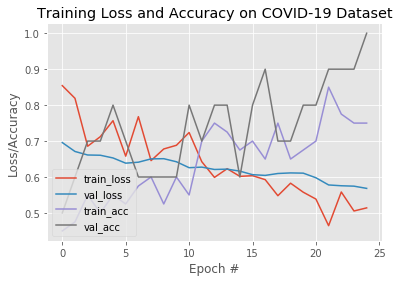

In [29]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
#base_model_V19 = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, channels)))

In [ ]:
#model_head = base_model_V19.output
#model_head = MaxPooling2D(pool_size=(4, 4))(model_head)
#model_head = Flatten(name="flatten")(model_head)
#model_head = Dense(64, activation="relu")(model_head)
#model_head = Dropout(0.5)(model_head)
#model_head = Dense(1, activation="sigmoid")(model_head)

In [ ]:
#Attach base model and head model together for training on image_set
#model_V19 = Model(inputs = base_model_V19.input, outputs = model_head)

#freeze base model for training
#for layer in base_model_V19.layers:
#    layer.trainable = False

In [ ]:
#print("Compiling COVID-19 VGG19 model...")
#opt = Adam(lr=learning_rate, decay=rate_decay)
#model_V19.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
#print("Training COVID-19 model head...")
#H_V19 = model_V19.fit_generator(train_image_aug.flow(train_X, train_Y, batch_size=batch_size),
#                        steps_per_epoch = 200,
#                        validation_data = (test_X, test_Y),
#                        validation_steps = len(test_X) // batch_size,
#                        epochs=epochs)